In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from models.diffusion import linear_beta_schedule, q_sample

c:\Users\zimen\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timesteps = 200

# define beta schedule (noise)
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculate for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculate for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [3]:

image = Image.open('dog.jpg')

In [4]:
image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [5]:
reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2),
    Lambda(lambda t: t.permute(1, 2, 0)),
    Lambda(lambda t: t * 255),
    Lambda(lambda t: t.numpy().astype(np.uint8)),
    ToPILImage(),
])

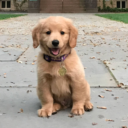

In [6]:
reverse_transform(x_start.squeeze())

In [7]:
def get_noisy_image(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    # add nosie
    x_noise = q_sample(x_start, t=t, sqrt_alphas_cumprod=sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod)
    noisy_image = reverse_transform(x_noise.squeeze())

    return noisy_image

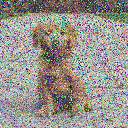

In [8]:
# take time step
t = torch.tensor([50])

get_noisy_image(x_start, t, sqrt_alphas_cumprod=sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod)

In [9]:
# use seed for repro
torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original Image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    
    plt.tight_layout()

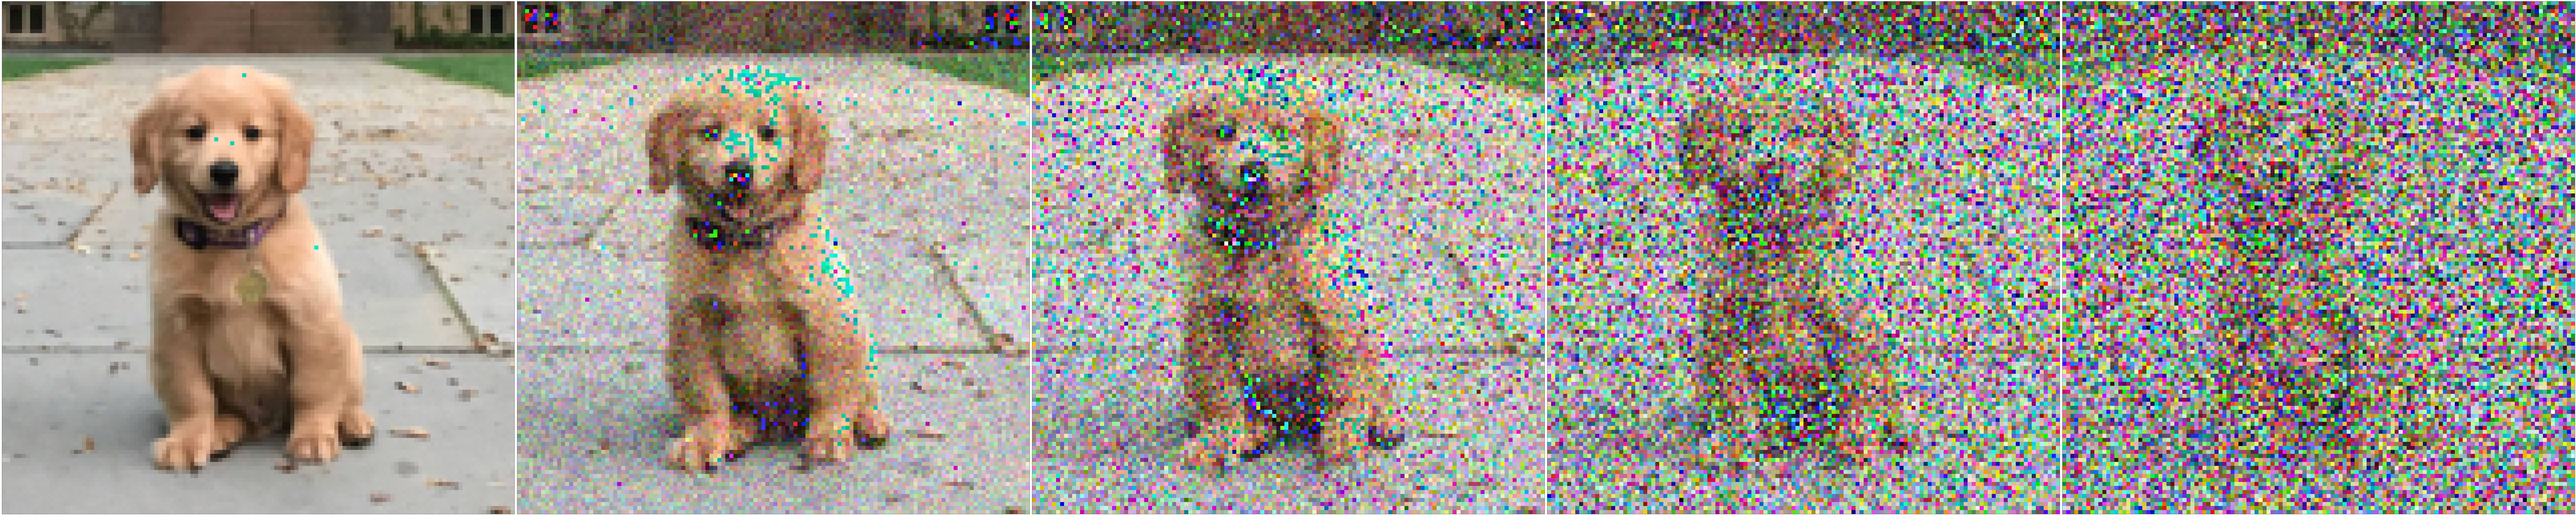

In [10]:
plot([get_noisy_image(x_start, torch.tensor([t]), sqrt_alphas_cumprod=sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod) for t in [0, 20, 40, 60, 80]])